# 意思決定分析と予測の活用｜第5部　確率予測とその活用
https://logics-of-blue.com/decision-analysis-and-forecast-book-support/

## 第2章　確率予測の活用

### Pythonによる分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# DataFrameの全角文字の出力をきれいにする
pd.set_option('display.unicode.east_asian_width', True)
# 本文の数値とあわせるために、小数点以下3桁で丸める
pd.set_option('display.precision', 3)
%precision 3

# グラフ描画
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

# sklearn関連
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, brier_score_loss, roc_curve, 
    plot_roc_curve, auc)
from sklearn.calibration import calibration_curve

### データ準備

In [2]:
# データの読み込み
data = pd.read_csv('5-2-sample-data.csv', index_col=0)
print(data.head(3))

     y    X_1    X_2    X_3    X_4
0  1.0  2.952  1.057  0.622  2.558
1  0.0 -0.953 -2.613  0.083 -0.826
2  1.0 -0.680  0.513 -0.450 -0.590


In [3]:
y = data.iloc[:, 0]  # 応答変数
X = data.iloc[:, 1:] # 説明変数

### 訓練データとテストデータへの分割

In [4]:
# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=1)

In [5]:
print('訓練データ　', X_train.shape)
print('テストデータ', X_test.shape)

訓練データ　 (6000, 4)
テストデータ (4000, 4)


### ロジスティック回帰モデルによる予測

In [6]:
# ロジスティック回帰
mod_logistic = LogisticRegression().fit(X_train, y_train)

In [7]:
# カテゴリー予測
category_pred = mod_logistic.predict(X_test)
category_pred

array([0., 1., 1., ..., 0., 1., 1.])

In [8]:
# 確率予測
prob_pred = mod_logistic.predict_proba(X_test)[:, 1]
prob_pred

array([0.183, 1.   , 0.837, ..., 0.02 , 0.752, 0.92 ])

### カテゴリー予測の評価

#### 指標を使った評価

In [9]:
# 分割表から計算される各種指標
print(f'的中率：{accuracy_score(y_test, category_pred):.3g}')
print(f'適合率：{precision_score(y_test, category_pred):.3g}')
print(f'再現率：{recall_score(y_test, category_pred):.3g}')
print(f'F値　 ：{f1_score(y_test, category_pred):.3g}')

的中率：0.876
適合率：0.879
再現率：0.868
F値　 ：0.874


#### 分割表による評価

In [10]:
# 分割表
confusion_matrix(y_test, category_pred)

array([[1800,  235],
       [ 259, 1706]], dtype=int64)

In [11]:
# 参考：True Negative(的中)
sum((y_test == category_pred) & (y_test == 0))

1800

In [12]:
# 参考：True Positive(的中)
sum((y_test == category_pred) & (y_test == 1))

1706

In [13]:
# 参考：False Positive(見逃し)
sum((y_test != category_pred) & (y_test == 1))

259

In [14]:
# 参考：False Negative(空振り)
sum((y_test != category_pred) & (y_test == 0))

235

In [15]:
# 参考：同時分布
confusion_matrix(y_test, category_pred, normalize='all')

array([[0.45 , 0.059],
       [0.065, 0.426]])

In [16]:
# 参考：予測の条件付き分布
confusion_matrix(y_test, category_pred, normalize='pred')

array([[0.874, 0.121],
       [0.126, 0.879]])

In [17]:
# 自然の状態の条件付き分布
conditional_state = confusion_matrix(y_test, category_pred, normalize='true')
conditional_state

array([[0.885, 0.115],
       [0.132, 0.868]])

In [18]:
# 真陽性率と偽陽性率
print(f'TPR(真陽性率)：{conditional_state[1,1]:.3g}')
print(f'FPR(偽陽性率)：{conditional_state[0,1]:.3g}')

TPR(真陽性率)：0.868
FPR(偽陽性率)：0.115


In [19]:
# 参考：度数から真陽性率と偽陽性率を計算する
freq_mat = confusion_matrix(y_test, category_pred)
print(f'TPR(真陽性率)：{(freq_mat[1,1] / (freq_mat[1,1] + freq_mat[1,0])):.3g}')
print(f'FPR(偽陽性率)：{(freq_mat[0,1] / (freq_mat[0,1] + freq_mat[0,0])):.3g}')

TPR(真陽性率)：0.868
FPR(偽陽性率)：0.115


### ブライアスコアによる確率予測の評価

In [20]:
# ブライアスコア
sum((prob_pred - y_test)**2) / len(y_test)

0.089

In [21]:
# ブライアスコア
BS = brier_score_loss(y_test, prob_pred)
print(f'ブライアスコア：{BS:.3g}')

ブライアスコア：0.0894


In [22]:
# 平均的な問題発生率
p_naive = sum(y_test) / len(y_test)
# BS_naive
BS_naive = brier_score_loss(y_test, np.repeat(p_naive, len(y_test)))

In [23]:
# ブライアスキルスコア
BSS = (BS_naive - BS) / BS_naive
print(f'ブライアスキルスコア：{BSS:.3g}')

ブライアスキルスコア：0.642


### 信頼度曲線

In [24]:
# 信頼度曲線を描くための区分ごと集計値
prob_true_class, prob_pred_class = calibration_curve(y_test, prob_pred, 
                                                     n_bins=11)

In [25]:
# 参考：予測された確率
prob_pred_class

array([0.029, 0.134, 0.225, 0.316, 0.409, 0.498, 0.596, 0.683, 0.774,
       0.869, 0.977])

In [26]:
# 参考：正しい確率
prob_true_class

array([0.04 , 0.132, 0.195, 0.268, 0.362, 0.478, 0.55 , 0.67 , 0.67 ,
       0.867, 0.981])

Text(0, 0.5, '実際の確率')

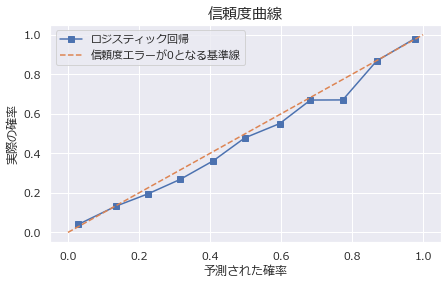

In [27]:
# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 信頼度曲線
ax.plot(prob_pred_class, prob_true_class, marker='s', 
        label='ロジスティック回帰')

# 信頼度エラーが0となる基準線
ax.plot([0, 1], [0, 1], linestyle='--', label='信頼度エラーが0となる基準線')

# グラフの装飾
ax.legend()                              # 凡例
ax.set_title('信頼度曲線', fontsize=15)  # タイトル
ax.set_xlabel('予測された確率')          # X軸ラベル
ax.set_ylabel('実際の確率')              # Y軸ラベル

### Sharpnessの評価

Text(0, 0.5, '度数')

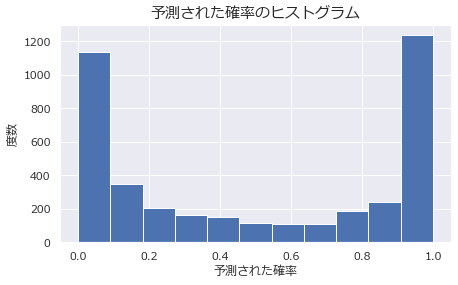

In [28]:
# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 予測された確率のヒストグラム
ax.hist(prob_pred, bins=11)

# グラフの装飾
ax.set_title('予測された確率のヒストグラム', fontsize=15)  # タイトル
ax.set_xlabel('予測された確率')                            # X軸ラベル
ax.set_ylabel('度数')                                      # Y軸ラベル

### 確率予測をカテゴリー予測に変換する

In [29]:
# 確率予測をカテゴリー予測に変換する関数
def prob_to_category(prob_pred, threshold):
    return((prob_pred >= threshold).astype(int))

In [30]:
# 参考：カテゴリー予測に変換された予測値
prob_to_category(prob_pred, 0.5)

array([0, 1, 1, ..., 0, 1, 1])

In [31]:
# カテゴリー予測と等しくなることの確認
all(category_pred == prob_to_category(prob_pred, 0.5))

True

In [32]:
# 予測の分割表を作る関数
def prob_to_mat(prob_pred, threshold, y_true, print_acc=True):
    # 確率予測をカテゴリー予測に変換
    category_pred = prob_to_category(prob_pred, threshold)
    # 必要に応じて、指標をprintする
    if(print_acc):
        conditional_state = confusion_matrix(y_true, category_pred, 
                                             normalize='true')
        print(f'的中率       ：{accuracy_score(y_true, category_pred):.3g}')
        print(f'TPR(真陽性率)：{conditional_state[1,1]:.3g}')
        print(f'FPR(偽陽性率)：{conditional_state[0,1]:.3g}')
        
    # DataFrameに変換した分割表を返す
    joint_forecast_state = pd.DataFrame(
        confusion_matrix(y_true, category_pred, normalize='all'), 
        columns=['予測-問題なし', '予測-問題あり'],
        index=['問題なし', '問題あり'])
    return(joint_forecast_state)

In [33]:
print(prob_to_mat(prob_pred, 0.5, y_test))

的中率       ：0.876
TPR(真陽性率)：0.868
FPR(偽陽性率)：0.115
          予測-問題なし  予測-問題あり
問題なし          0.450          0.059
問題あり          0.065          0.426


### ROC曲線とAUC

In [34]:
# TPRとFPR　「あり予測」を増やすことで、空振りを増やし、見逃しを減らす
tmp = prob_to_mat(prob_pred, 0.1, y_test)

的中率       ：0.76
TPR(真陽性率)：0.975
FPR(偽陽性率)：0.448


In [35]:
# TPRとFPR　「あり予測」を減らすことで、空振りを減らし、見逃しを増やす
tmp = prob_to_mat(prob_pred, 0.9, y_test)

的中率       ：0.812
TPR(真陽性率)：0.632
FPR(偽陽性率)：0.0133


Text(0, 0.5, '真陽性率')

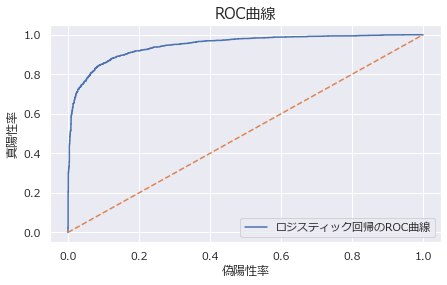

In [36]:
# 真陽性率と偽陽性率、閾値を得る
fpr, tpr, threshold = roc_curve(y_test, prob_pred)

# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 信頼度曲線
ax.step(fpr, tpr, label='ロジスティック回帰のROC曲線')

# まったく役に立たない予測だった場合のROC曲線
ax.plot([0, 1], [0, 1], linestyle='--')

# グラフの装飾
ax.legend()                           # 凡例
ax.set_title('ROC曲線', fontsize=15)  # タイトル
ax.set_xlabel('偽陽性率')             # X軸ラベル
ax.set_ylabel('真陽性率')             # Y軸ラベル

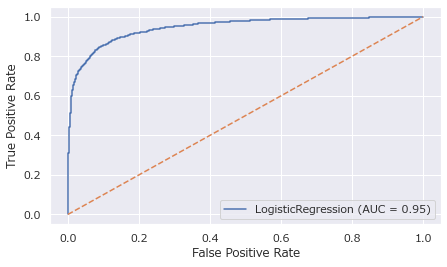

In [37]:
# 参考：簡易的な描画方法
fig, ax = plt.subplots(figsize=(7, 4))
plot_roc_curve(mod_logistic, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--')

In [38]:
# AUC
print(f'AUC：{auc(fpr, tpr):.3g}')

AUC：0.947


### 意思決定に関わる要素の整理

In [39]:
payoff = pd.DataFrame({
    '対策なし': [1000, 0],
    '対策あり': [200, 200]
})
payoff.index = ['問題なし', '問題あり']
print(payoff)

          対策なし  対策あり
問題なし      1000       200
問題あり         0       200


In [40]:
# 最大値をとるインデックスを取得する。最大値が複数ある場合はすべて出力する。
def argmax_list(series):
    return(list(series[series == series.max()].index))

In [41]:
# 期待金額最大化に基づく意思決定を行う関数
def max_emv(probs, payoff_table):
    emv = payoff_table.mul(probs, axis=0).sum()
    max_emv = emv.max()
    a_star = argmax_list(emv)
    return(pd.Series([a_star, max_emv], index=['選択肢', '期待金額']))

### 予測を使わないときの期待金額の最大化

In [42]:
joint_forecast_state = prob_to_mat(prob_pred, 0.5, y_test, print_acc=False)
print(joint_forecast_state)

          予測-問題なし  予測-問題あり
問題なし          0.450          0.059
問題あり          0.065          0.426


In [43]:
# 自然の状態の周辺分布
marginal_state = joint_forecast_state.sum(axis=1)
marginal_state

問題なし    0.509
問題あり    0.491
dtype: float64

In [44]:
naive_decision = max_emv(marginal_state, payoff)
naive_decision

選択肢      [対策なし]
期待金額           509
dtype: object

### カテゴリー予測を使うときの期待金額の最大化

In [45]:
# 予測の周辺分布
marginal_forecast = joint_forecast_state.sum(axis=0)
marginal_forecast

予測-問題なし    0.515
予測-問題あり    0.485
dtype: float64

In [46]:
# 予測が得られた後の条件付き分布
conditional_forecast = joint_forecast_state.div(marginal_forecast, axis=1)
print(conditional_forecast)

          予測-問題なし  予測-問題あり
問題なし          0.874          0.121
問題あり          0.126          0.879


In [47]:
info_decision = \
    conditional_forecast.apply(max_emv, axis=0, payoff_table=payoff)
print(info_decision)

         予測-問題なし 予測-問題あり
選択肢      [対策なし]    [対策あり]
期待金額           874           200


In [48]:
info_decision.loc['期待金額'].mul(marginal_forecast).sum()

547.050

In [49]:
joint_forecast_state.apply(
    max_emv, axis=0, payoff_table=payoff).loc['期待金額'].sum()

547.050

### 確率予測を使うときの期待金額

In [50]:
# 閾値を指定したうえで、確率予測をカテゴリー予測に変換し、
# その結果に基づいて意思決定を行ったときの最大の期待金額を返す関数
def prob_pred_emv(prob_pred, threshold, y_true, payoff_table, 
                  print_acc=False):
    # 確率予測をカテゴリー予測に変換して、同時分布を得る
    joint_forecast_state = prob_to_mat(prob_pred, threshold, y_true, 
                                       print_acc)
    # カテゴリー予測と自然の状態の同時分布に基づいて意思決定をし
    # 期待金額の最大値を返す
    emv = joint_forecast_state.apply(
        max_emv, axis=0, payoff_table=payoff_table).loc['期待金額'].sum()
    return(emv)

In [51]:
# 動作確認
prob_pred_emv(prob_pred, 0.5, y_test, payoff)

547.050

In [52]:
# コストロス比を閾値にする
prob_pred_emv(prob_pred, 0.8, y_test, payoff)

566.600

In [53]:
# 予測を使わないときのEMV
emv_naive = naive_decision.loc['期待金額']

# 予測を使うときのEMV
emv_category = prob_pred_emv(prob_pred, 0.5, y_test, payoff)
emv_prob = prob_pred_emv(prob_pred, 0.8, y_test, payoff)

# 予測の価値
evsi_category =  emv_category - emv_naive
evsi_prob = emv_prob - emv_naive
print(f'カテゴリー予測の価値：{evsi_category:.3g}')
print(f'確率予測の価値      ：{evsi_prob:.3g}')

カテゴリー予測の価値：38.3
確率予測の価値      ：57.8


### 確率予測を使うときの期待金額の最大化

In [54]:
# 閾値を0から1まで変化させる
threshold_array = np.arange(0, 1.01, 0.01)
# 各々の閾値でEMVを計算する
emv_array = np.zeros(len(threshold_array))
for i in range(len(threshold_array)):
    emv_array[i] = prob_pred_emv(prob_pred, threshold_array[i], 
                                 y_test, payoff)

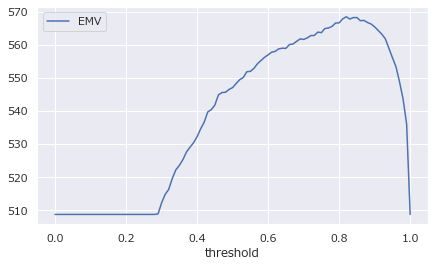

In [55]:
# DataFrameにまとめる
prob_pred_emv_df = pd.DataFrame({
    'EMV': emv_array,
    'threshold':threshold_array
})

# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 折れ線グラフの描画
prob_pred_emv_df.plot(x='threshold', y='EMV', ax=ax)

In [56]:
# 期待金額が最大のときの閾値とそのときのEMV
prob_pred_emv_df.iloc[prob_pred_emv_df['EMV'].idxmax()]

EMV          568.45
threshold      0.82
Name: 82, dtype: float64

In [57]:
# 閾値をチューニングしたときの予測の価値
emv_prob_best = prob_pred_emv_df['EMV'].max()
evsi_prob_best = emv_prob_best - emv_naive
print(f'閾値を変更したときの価値：{evsi_prob_best:.3g}')

閾値を変更したときの価値：59.7


In [58]:
# 参考；情報の価値の比較
print(f'カテゴリー予測の価値    ：{evsi_category:.3g}')
print(f'確率予測の価値          ：{evsi_prob:.3g}')
print(f'閾値を変更したときの価値：{evsi_prob_best:.3g}')

カテゴリー予測の価値    ：38.3
確率予測の価値          ：57.8
閾値を変更したときの価値：59.7
